# Sample frequency simulations

## Chi-squared test and range test

We test whether each sample $1, \dots, N = {n \choose k}$ is selected with equal probability. We do two tests: the usual chi-squared test and another test based on the range of the multinomial values, $max_i n_i - min_i n_i$, where $n_1, \dots, n_N$ are the number of items in each of $N$ cells that have equal probability $1/N$.

Johnson and Young (1960) and Young (1962) provide the following approximation to the distribution of the range

$$P(\max_i n_k - \min_i n_k \leq r) \approx P(W_N \leq (r-(2B)^{-1})(N/B)^{1/2})$$

where $W_N$ denotes the sample range of $N$ independent standard normal random variables and $B$ is the number of multinomial draws. It is a known result (see e.g. Pearson and Hartley p. 43, 1954 or Ruben, 1960) that the distribution function for the range of $B$ IID normal samples is given by

$$R(w) = B \int_{-\infty}^{\infty} \phi(x)\left[ \Phi(x+w) - \Phi(x)\right]^{B-1}dx$$

where $\phi$ and $\Phi$ are the standard normal density and cumulative distribution function, respectively.  We leverage these two results to approximate the p-value of the range statistic.

## Variability across seeds

To run these tests, we generate a large number $B$ simple random samples starting at a particular seed. For any arbitrary choice of $B$ and seed, the $B$ simple random samples may or may not appear sufficiently uniformly random. What we are really interested in is how a PRNG behaves on the whole, across different seed values.

If the null hypothesis that samples occur with equal frequency is true, then the $p$-values for the chi-squared and range tests should be uniformly distributed. The $p$-value for a test starting with a particular seed may be very small and lead to rejection, but if we run the test for many different seeds, then we should only reject the test at level $\alpha$ for $100 \alpha \%$ of the seeds.

Using $B$ samples ranging from $10^5$ to $10^7$ generated from each PRNG, we run the chi-squared and range tests for 1000 different seeds. This gives us 1000 $p$-values for each test and value of $B$. Finally, we run a Kolmogorov-Smirnov test to compare the disribution of these 1000 $p$-values to a uniform distribution.

## Summary of results

We ran these tests taking samples of size $k=3$ or $k=10$ from a population of $n=13$. We used both the PIKK and sample_by_index sampling algorithms. We compared Mersenne Twister (MT), Super Duper LCG (SD), and the SHA256 PRNG.

The experiments for which the Kolmogorov-Smirnov test detected a statistically significant departure from uniformity were all of the experiments using SD and the one using MT to sample $k=10$ with PIKK. 

Across the board, the $p$-values from SD were non-uniform. They skewed to favor large $p$-values. This is especially apparent when looking at histograms of the $p$-values from the chi-squared test. The skew is less prominent for the range test.

$P$-values for MT and SHA256 tended to be uniformly distributed. The range test $p$-values tended to be closer to uniform for MT than for SHA256 (they had smaller KS statistics), but there was no systematic pattern for the chi-squared test.

In [1]:
library(dplyr)
library(reshape2)
library(ggplot2)
options(warn = (-1))


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



In [2]:
combinations <- expand.grid(c("MT", "SD", "SHA256"),
                            c(2, 3, 10),
                            c(13, 30),
                            c("PIKK", "sbi"))
colnames(combinations) <- c("PRNG", "SampleSize", "PopSize", "Algorithm")
combinations <- combinations %>% 
                    filter(!(SampleSize == 2 & PopSize == 13)) %>%
                    filter(!(SampleSize == 3 & PopSize == 30)) %>%
                    filter(!(SampleSize == 2 & PopSize == 30)) %>%
                    filter(!(SampleSize == 10 & PopSize == 30))

rawdatafiles <- list.files("../rawdata/")

res <- lapply(1:nrow(combinations), function(index){
  filename <- paste0(combinations[index, 1],
                     "_1000seeds_", combinations[index, 4],
                     "_n", combinations[index, 3],
                     "_k", combinations[index, 2], ".csv")
  if(!(filename %in% rawdatafiles)){ return()}
  
  tmp <- read.csv(paste0("../rawdata/", filename), header = TRUE, stringsAsFactors=FALSE)
  tmp$PRNG <- rep(combinations[index, 1], nrow(tmp))
  tmp$algorithm <- rep(combinations[index, 4], nrow(tmp))
  return(tmp)
})
res <- do.call(rbind, res)
head(res)

dim(res)

seed,reps,PopSize,SampleSize,chisqStat,chisqDF,chisqPvalue,rangeStat,rangePvalue,PRNG,algorithm
739828299,100000,13,3,277.5316,285,0.6131737,113,0.2600749,MT,PIKK
739828299,1200000,13,3,263.4101,285,0.8159651,318,0.9501520,MT,PIKK
739828299,2300000,13,3,285.1089,285,0.4870420,498,0.5944001,MT,PIKK
739828299,3400000,13,3,297.7452,285,0.2898210,595,0.6661380,MT,PIKK
739828299,4500000,13,3,288.0705,285,0.4379954,685,0.6633117,MT,PIKK
739828299,5600000,13,3,276.2172,285,0.6344703,772,0.6216628,MT,PIKK


[1] 120000     11

# KS Test of uniformity of $p$-values

Below, we compute Kolmogorov-Smirnov statistics and $p$-values for $10^7$ samples.

In [3]:
range_pvalue_kstest <- sapply(1:nrow(combinations), function(row){
    res %>% filter(PRNG == combinations[row, 1],
                  SampleSize == combinations[row, 2],
                  PopSize == combinations[row, 3],
                  algorithm == combinations[row, 4],
                  reps == 1e7) %>%
    select(rangePvalue) %>% 
    ks.test(y = punif)
    })

chisq_pvalue_kstest <- sapply(1:nrow(combinations), function(row){
    res %>% filter(PRNG == combinations[row, 1],
                  SampleSize == combinations[row, 2],
                  PopSize == combinations[row, 3],
                  algorithm == combinations[row, 4],
                  reps == 1e7) %>%
    select(chisqPvalue) %>% 
    ks.test(y = punif)
    })


displ_res <- cbind(combinations, t(range_pvalue_kstest[1:2,]), t(chisq_pvalue_kstest[1:2,]))
colnames(displ_res)[5:8] <- c("Range KS Stat", "Range KS Pvalue", 
                              "Chisq KS Stat", "Chisq KS Pvalue")
displ_res %>% arrange(PRNG)

PRNG,SampleSize,PopSize,Algorithm,Range KS Stat,Range KS Pvalue,Chisq KS Stat,Chisq KS Pvalue
MT,3,13,PIKK,0.02033537,0.8026752,0.0296388,0.343387
MT,10,13,PIKK,0.0537681,0.00616498,0.03933686,0.0905618
MT,3,13,sbi,0.02177979,0.7298936,0.02467927,0.5762909
MT,10,13,sbi,0.02418522,0.6023116,0.03764955,0.1174159
SD,3,13,PIKK,0.0627056,0.0007686784,0.1676098,0
SD,10,13,PIKK,0.06012619,0.001448581,0.1431423,0
SD,3,13,sbi,0.066951,0.0002556439,0.1490059,0
SD,10,13,sbi,0.070318,0.0001014347,0.1129473,1.660971e-11
SHA256,3,13,PIKK,0.02450477,0.5854502,0.01803101,0.9011261
SHA256,10,13,PIKK,0.03387934,0.2011924,0.0364356,0.1405339


## P-value plots for $10^7$ samples

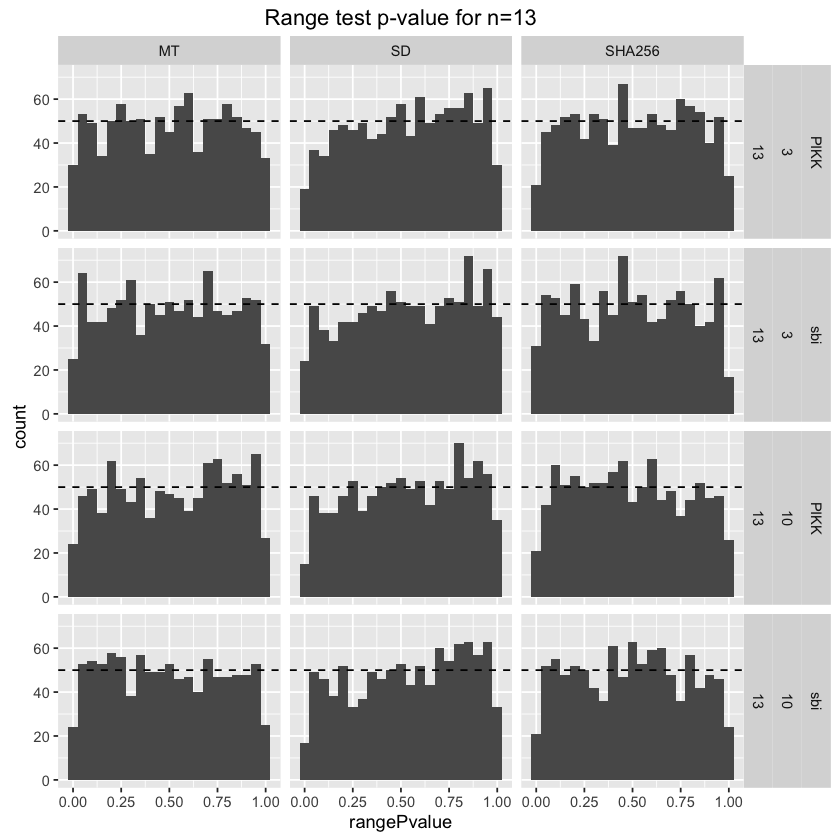

In [4]:
res %>% 
    filter(reps == 1e7) %>%
    ggplot(aes(rangePvalue)) + 
    geom_histogram(binwidth=0.05) +
    facet_grid(PopSize+SampleSize+algorithm~PRNG) +
    ggtitle("Range test p-value for n=13") +
    geom_hline(yintercept = 1000*0.05, linetype = "dashed")

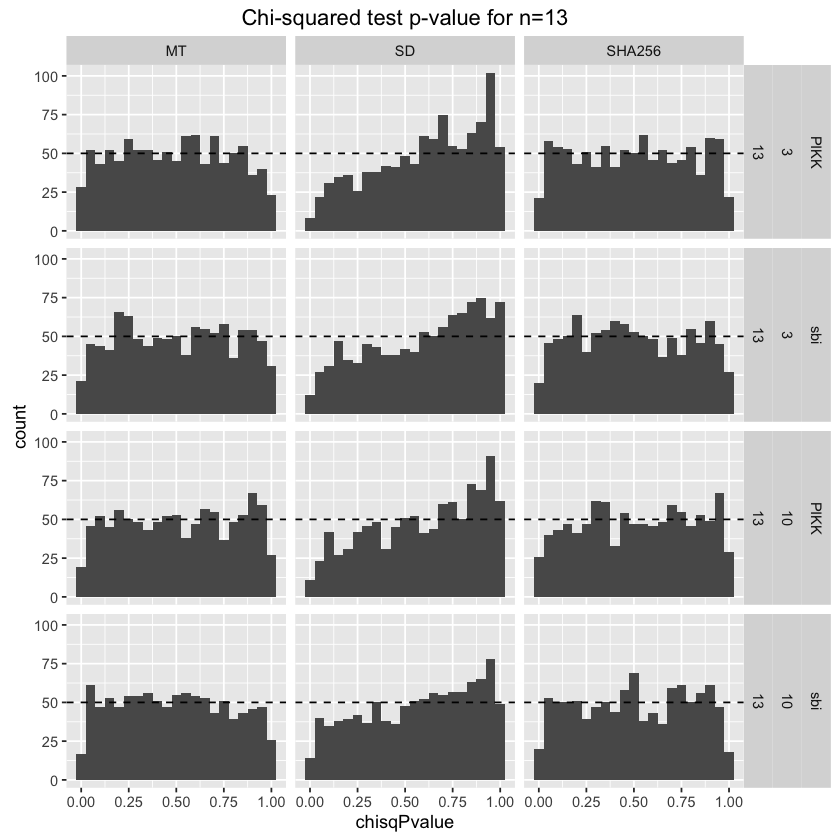

In [5]:
res %>% 
    filter(reps == 1e7) %>%
    ggplot(aes(chisqPvalue)) + 
    geom_histogram(binwidth=0.05) +
    facet_grid(PopSize+SampleSize+algorithm~PRNG) +
    ggtitle("Chi-squared test p-value for n=13") +
    geom_hline(yintercept = 1000*0.05, linetype = "dashed")

# KS Test of uniformity of $p$-values

Below, we compute Kolmogorov-Smirnov statistics and $p$-values for $10^5$ samples.

In [6]:
range_pvalue_kstest <- sapply(1:nrow(combinations), function(row){
    res %>% filter(PRNG == combinations[row, 1],
                  SampleSize == combinations[row, 2],
                  PopSize == combinations[row, 3],
                  algorithm == combinations[row, 4],
                  reps == 1e5) %>%
    select(rangePvalue) %>% 
    ks.test(y = punif)
    })

chisq_pvalue_kstest <- sapply(1:nrow(combinations), function(row){
    res %>% filter(PRNG == combinations[row, 1],
                  SampleSize == combinations[row, 2],
                  PopSize == combinations[row, 3],
                  algorithm == combinations[row, 4],
                  reps == 1e5) %>%
    select(chisqPvalue) %>% 
    ks.test(y = punif)
    })


displ_res <- cbind(combinations, t(range_pvalue_kstest[1:2,]), t(chisq_pvalue_kstest[1:2,]))
colnames(displ_res)[5:8] <- c("Range KS Stat", "Range KS Pvalue", 
                              "Chisq KS Stat", "Chisq KS Pvalue")
displ_res %>% arrange(PRNG)

PRNG,SampleSize,PopSize,Algorithm,Range KS Stat,Range KS Pvalue,Chisq KS Stat,Chisq KS Pvalue
MT,3,13,PIKK,0.03977461,0.08450313,0.04098926,0.06945101
MT,10,13,PIKK,0.06027976,0.00139599,0.04136509,0.06528264
MT,3,13,sbi,0.03307485,0.2239894,0.01921795,0.8538914
MT,10,13,sbi,0.04018855,0.07909125,0.0257681,0.5201672
SD,3,13,PIKK,0.04218855,0.05689075,0.02322701,0.6532925
SD,10,13,PIKK,0.03805603,0.1104112,0.03289061,0.2294762
SD,3,13,sbi,0.03518293,0.1681119,0.05235078,0.008328593
SD,10,13,sbi,0.04927976,0.0155477,0.03846932,0.1036465
SHA256,3,13,PIKK,0.04077461,0.07193184,0.0195968,0.8371658
SHA256,10,13,PIKK,0.02996391,0.330524,0.0211282,0.7634162


## P-value plots for $10^5$ samples

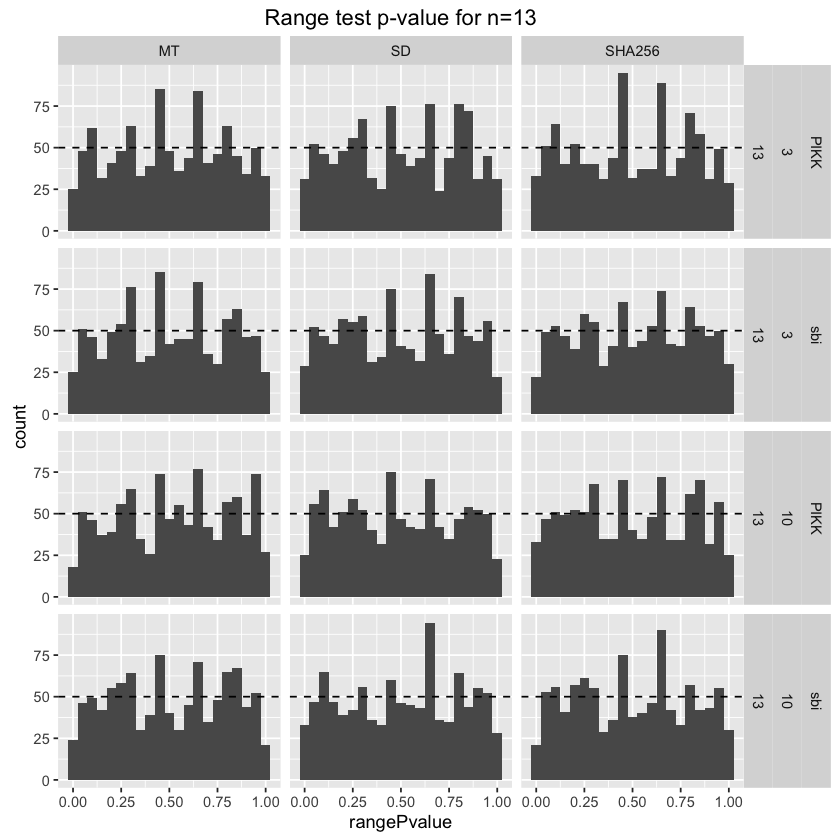

In [7]:
res %>% 
    filter(reps == 1e5) %>%
    ggplot(aes(rangePvalue)) + 
    geom_histogram(binwidth=0.05) +
    facet_grid(PopSize+SampleSize+algorithm~PRNG) +
    ggtitle("Range test p-value for n=13") +
    geom_hline(yintercept = 1000*0.05, linetype = "dashed")

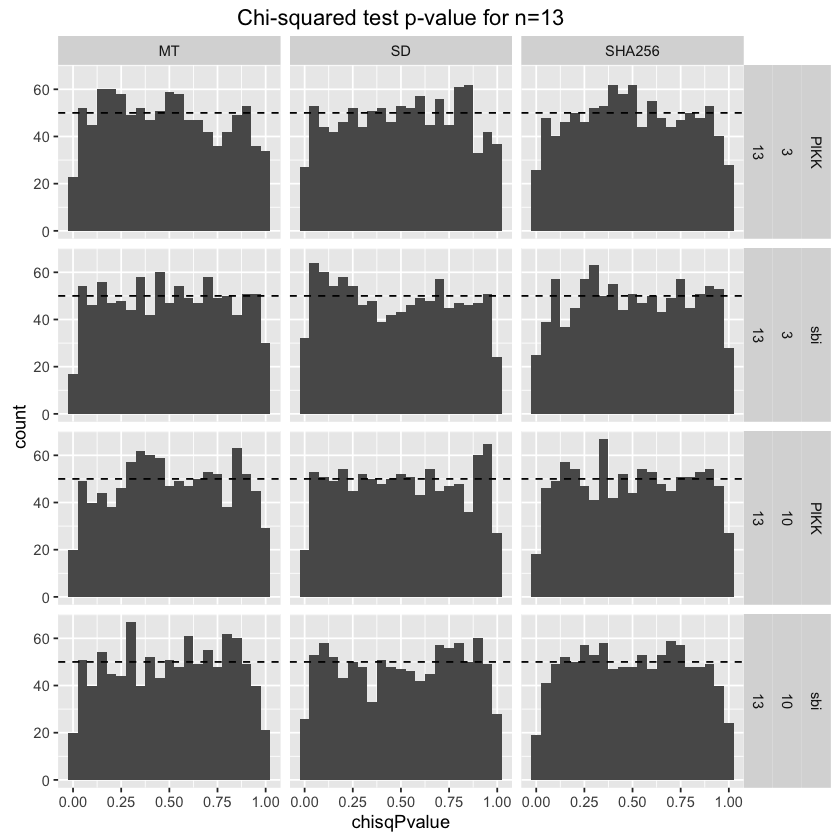

In [8]:
res %>% 
    filter(reps == 1e5) %>%
    ggplot(aes(chisqPvalue)) + 
    geom_histogram(binwidth=0.05) +
    facet_grid(PopSize+SampleSize+algorithm~PRNG) +
    ggtitle("Chi-squared test p-value for n=13") +
    geom_hline(yintercept = 1000*0.05, linetype = "dashed")

# Looking at plots for all varying reps

Adding missing grouping variables: `SampleSize`, `algorithm`, `PRNG`, `reps`


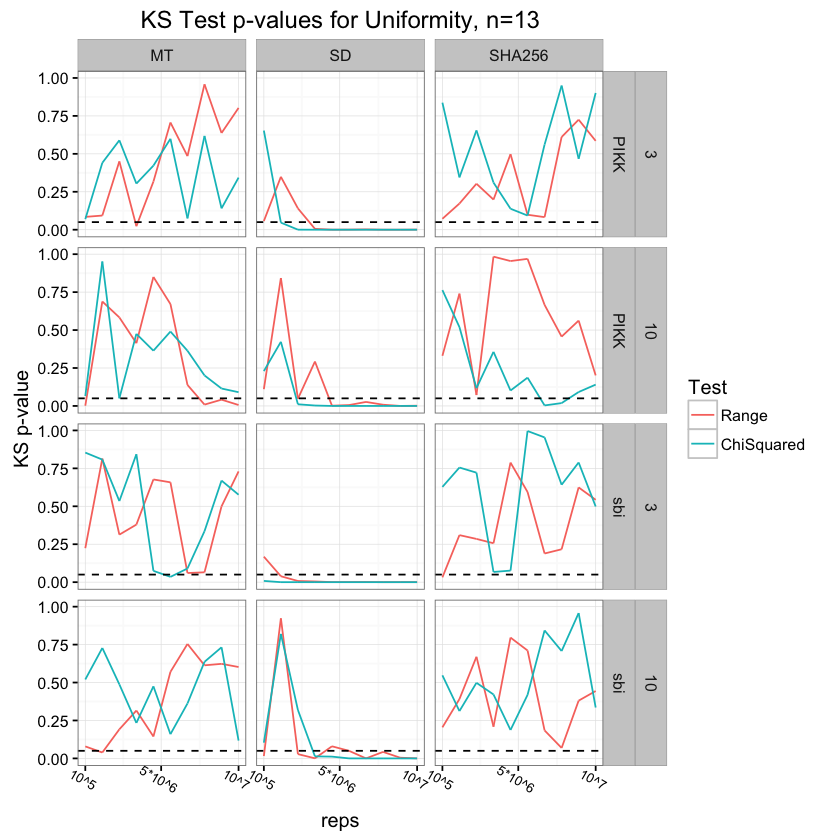

In [9]:
ks_unif <- function(x) ks.test(x, punif)$p.value
    
kstest_pvalues <- res %>% group_by(SampleSize, algorithm, PRNG, reps) %>%
    select(rangePvalue, chisqPvalue) %>% 
    mutate("Range"=ks_unif(rangePvalue),
           "ChiSquared"=ks_unif(chisqPvalue))
kstest_pvalues <- melt(kstest_pvalues, 
                       id.vars = c("SampleSize", "algorithm", "PRNG", "reps"), 
                       measure.vars = c("Range", "ChiSquared"))
    
kstest_pvalues %>% 
    ggplot(aes(x=reps, y=value, color=variable)) +
    geom_line() +
    facet_grid(algorithm+SampleSize~PRNG) +
    ggtitle("KS Test p-values for Uniformity, n=13") +
    geom_hline(yintercept = 0.05, linetype = "dashed") +
    theme_bw() + 
    labs(color='Test') +
    ylab("KS p-value") + 
    theme(axis.text.x = element_text(size=8, angle = -30)) +
    scale_x_continuous(breaks=c(10**5, 5*10**6, 10**7), labels=c("10^5", "5*10^6", "10^7"))

In [10]:
kstest_pvalues %>% filter(value <= 0.05, PRNG != "SD") %>% unique()

,SampleSize,algorithm,PRNG,reps,variable,value
1,3,PIKK,MT,3400000,Range,0.022939590
1001,10,PIKK,MT,100000,Range,0.001395990
1002,10,PIKK,MT,7800000,Range,0.008742615
1003,10,PIKK,MT,8900000,Range,0.041366711
1004,10,PIKK,MT,10000000,Range,0.006164980
5001,3,sbi,SHA256,100000,Range,0.031833209
6001,10,sbi,MT,1200000,Range,0.038907780
7001,10,PIKK,SHA256,6700000,ChiSquared,0.003309418
7002,10,PIKK,SHA256,7800000,ChiSquared,0.018784349
9001,3,sbi,MT,5600000,ChiSquared,0.035012499


# Correlation between seed and p-value

Is there evidence that certain seeds produce bad outputs? Does this vary with the number of zeros in the bit representation of the seed?

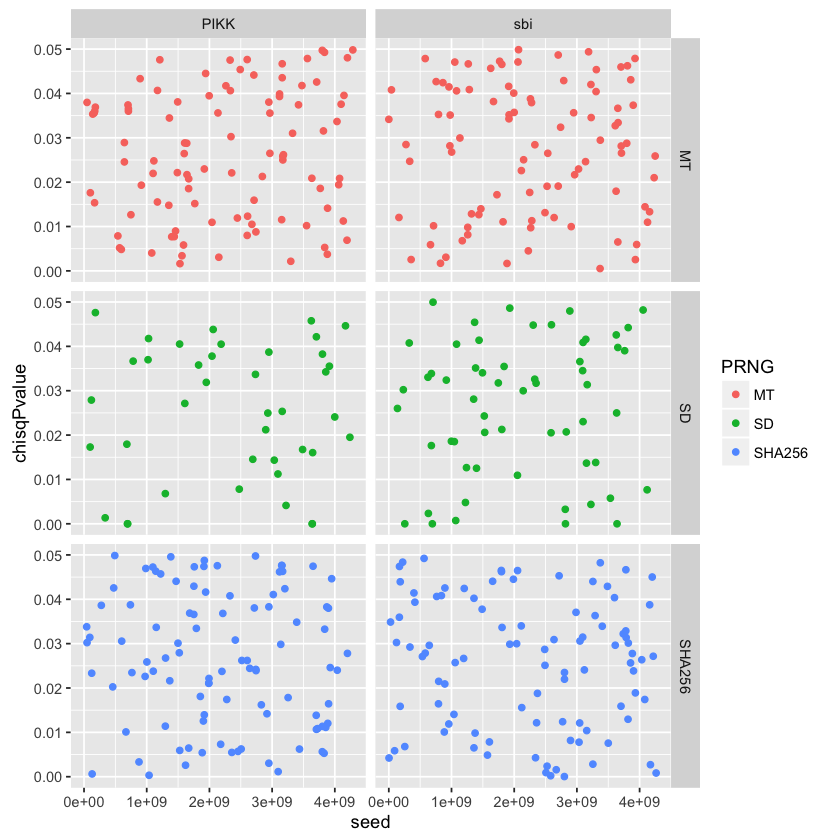

In [11]:
res %>% 
    filter(reps == 1e7, chisqPvalue <= 0.05) %>%
    ggplot(aes(seed, chisqPvalue, color=PRNG)) + 
    geom_point() +
    facet_grid(PRNG~algorithm)

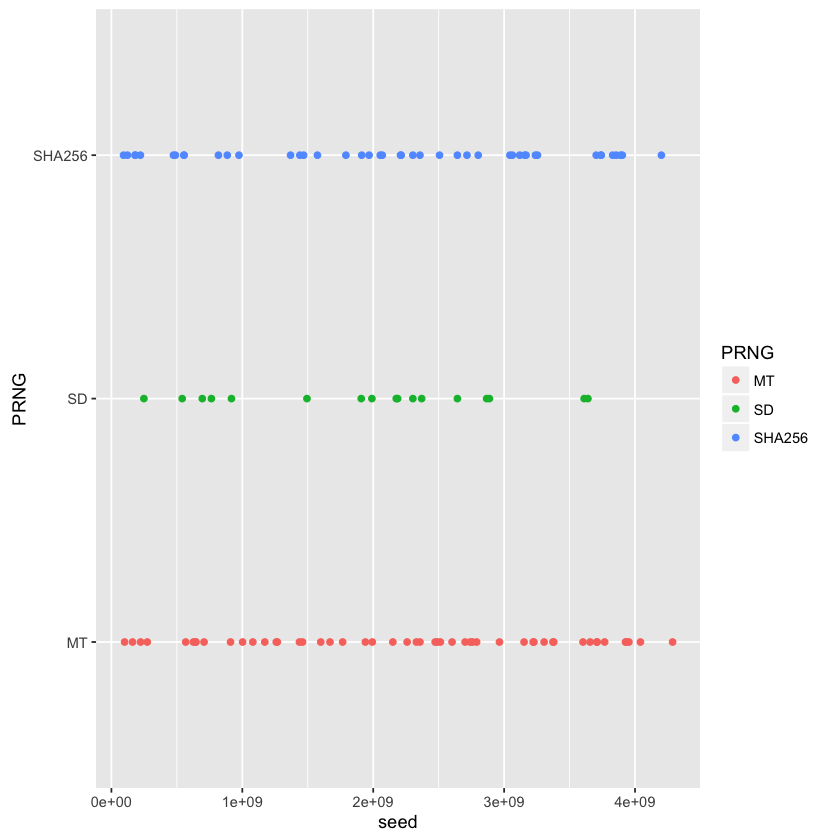

In [12]:
res %>% 
    filter(reps == 1e7, rangePvalue <= 0.05 | chisqPvalue <= 0.05) %>%
    group_by(PRNG) %>%
    count(seed) %>%
    filter(n > 1) %>%
    ggplot(aes(x = seed, y = PRNG, color = PRNG)) +
    geom_point()

In [13]:
tmp <- res %>% 
    filter(reps == 1e7, rangePvalue <= 0.05 | chisqPvalue <= 0.05) %>%
    group_by(PRNG) %>%
    count(seed) %>%
    filter(n > 1) 

tmp$bits <- sapply(tmp$seed, function(x) paste(substr(intToBits(x), start=2, stop=2), collapse = ""))
tmp$bits[tmp$seed >= 2^31] <- sapply(tmp$seed[tmp$seed >= 2^31], function(x) paste(substr(intToBits(x - 2^31), start=2, stop=2), collapse = ""))
tmp$nzeros <- sapply(tmp$bits, function(x) length(gregexpr("0", x)[[1]]))
tmp$nzeros_raw <- sapply(tmp$seed, function(x) length(gregexpr("0", x)[[1]]) )
tmp %>% arrange(desc(nzeros))

PRNG,seed,n,bits,nzeros,nzeros_raw
MT,100950840,2,00011100110001100010000001100000,22,4
MT,3227579402,2,01010000001011110000011000000010,22,1
SD,694311424,3,00000000010110100100011010010100,22,1
MT,2701855036,2,00111100100100001101000010000100,21,2
MT,3305440105,2,10010110110000001010000010100010,21,3
SHA256,885047335,2,11100100000000110000001100101100,21,1
SHA256,2208466569,2,10010001011000010100010111000000,21,1
SHA256,2801903114,2,01010000011001011000000011100100,21,2
SHA256,3254918380,3,00110111001110000100000001000010,21,1
MT,161825109,2,10101010100000101010010110010000,20,1


In [14]:
tmp <- res

tmp$bits <- sapply(tmp$seed, function(x) paste(substr(intToBits(x), start=2, stop=2), collapse = ""))
tmp$bits[tmp$seed >= 2^31] <- sapply(tmp$seed[tmp$seed >= 2^31], function(x) paste(substr(intToBits(x - 2^31), start=2, stop=2), collapse = ""))
tmp$nzeros <- sapply(tmp$bits, function(x) length(gregexpr("0", x)[[1]]))
tmp$nzeros_raw <- sapply(tmp$seed, function(x) length(gregexpr("0", x)[[1]]) )
tmp %>% arrange(desc(nzeros)) %>% head()

seed,reps,PopSize,SampleSize,chisqStat,chisqDF,chisqPvalue,rangeStat,rangePvalue,PRNG,algorithm,bits,nzeros,nzeros_raw
2760900804,100000,13,3,294.3370,285,0.3391640,103,0.6281829,MT,PIKK,00100011000000000000100100100100,25,4
2760900804,1200000,13,3,246.3921,285,0.9523666,371,0.4638346,MT,PIKK,00100011000000000000100100100100,25,4
2760900804,2300000,13,3,254.6872,285,0.9013900,557,0.1796598,MT,PIKK,00100011000000000000100100100100,25,4
2760900804,3400000,13,3,298.1034,285,0.2848577,608,0.5769795,MT,PIKK,00100011000000000000100100100100,25,4
2760900804,4500000,13,3,286.1943,285,0.4689640,760,0.2516581,MT,PIKK,00100011000000000000100100100100,25,4
2760900804,5600000,13,3,288.9164,285,0.4241885,790,0.5245927,MT,PIKK,00100011000000000000100100100100,25,4


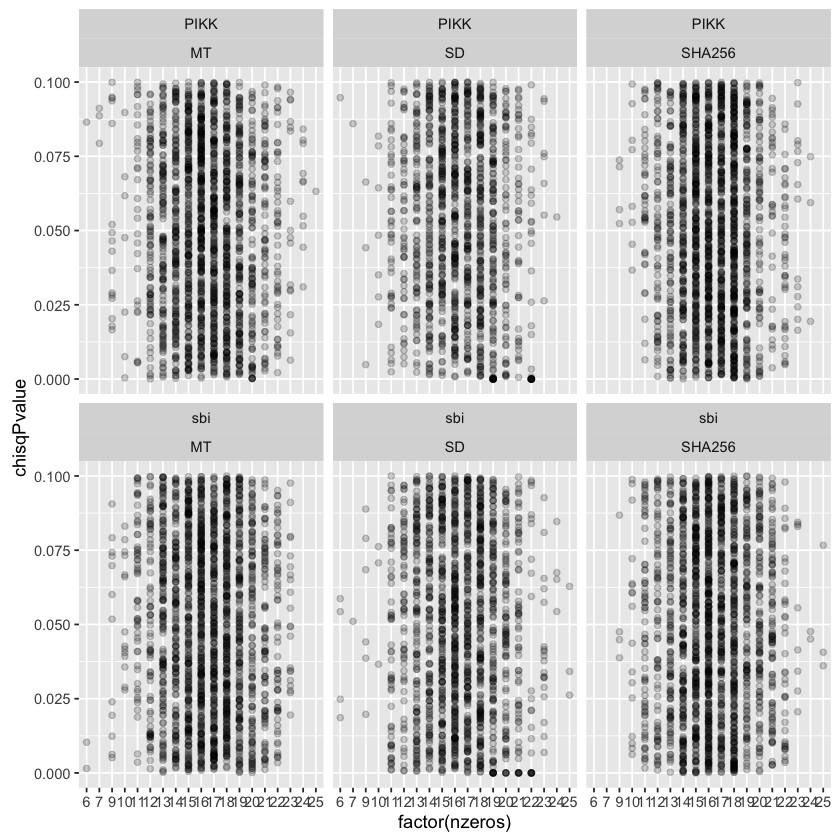

In [15]:
    tmp %>% filter(chisqPvalue <= 0.1) %>% 
    ggplot(aes(x = factor(nzeros), y = chisqPvalue)) + geom_point(alpha = 0.2) + facet_wrap(algorithm~PRNG)

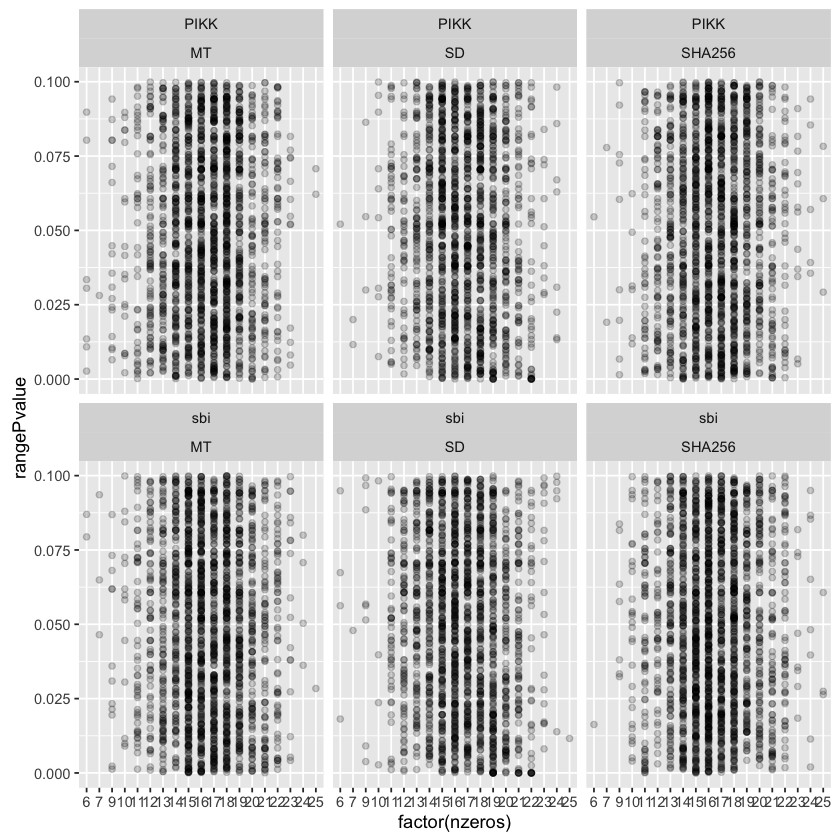

In [16]:
    
tmp %>% filter(nzeros < 31, rangePvalue <= 0.1) %>% 
    ggplot(aes(x = factor(nzeros), y = rangePvalue)) + geom_point(alpha = 0.2) + facet_wrap(algorithm~PRNG)